# New Image Classification Dataset

This notebook describes the process of preparing a user-provided image classification dataset (one not included in Hugging Face or Torchvision) for use in Armory Library.

In [1]:
import collections
from pathlib import Path

import datasets
import pandas as pd

import armory.data
import armory.dataset
import armory.evaluation
import armory.examples

[SAMPLE Public Dataset](https://github.com/benjaminlewis-afrl/SAMPLE_dataset_public)

The SAMPLE dataset (Synthetic and Measured Paired Labeled Experiment) dataset consists of measured SAR imagery from the MSTAR collection (Moving and Stationary Target Acquisition and Recognition) paired with synthetic SAR imagery. The public version of this dataset contains data with azimuth angles between 10 and 80 degrees.

The MSTAR dataset contains SAR imagery of 10 types of military vehicles illustrated in the EO images below.

<img src="mstar_10_targets.png"
    alt="MSTAR 10 Targets"
    width="700">

[Song, Haibo & Ji, Kefeng & Zhang, Yunshu & Xing, Xiang & Zou, Huanxin. (2016). Sparse Representation-Based SAR Image Target Classification on the 10-Class MSTAR Data Set. Applied Sciences. 6. 26. 10.3390/app6010026.](https://www.mdpi.com/2076-3417/6/1/26)

## Download dataset

As a first step, we clone the [SAMPLE dataset repository](https://github.com/benjaminlewis-afrl/SAMPLE_dataset_public) that contains the real and synthetic SAR imagery into a temporary location.

In [2]:
tmp_dir = Path('/tmp')
sample_dir = tmp_dir / Path('SAMPLE_dataset_public')

In [3]:
%%bash -s $sample_dir

if [[ -d $1 ]]
then
    echo "$1 exists"
else
    git clone https://github.com/benjaminlewis-afrl/SAMPLE_dataset_public $1
fi

Cloning into '/tmp/SAMPLE_dataset_public'...
Updating files: 100% (8073/8073), done.


### Dataset structure

The SAMPLE dataset is organized according to the [`ImageFolder`](https://huggingface.co/docs/datasets/v2.19.0/en/image_dataset#imagefolder) pattern. The imagery is split into two normalizations -- decibel and quarter power magnitude (QPM). For each normalization type, real and synthetic SAR imagery is partitioned into folders according to vehicle type.

In [4]:
!find $sample_dir -type d -not -path "$sample_dir/.git*" -not -path "$sample_dir/mat_files*" | sed -e "s/[^-][^\/]*\// |/g" -e "s/|\([^ ]\)/|-\1/"

 |-SAMPLE_dataset_public
 | |-png_images
 | | |-qpm
 | | | |-real
 | | | | |-m1
 | | | | |-t72
 | | | | |-btr70
 | | | | |-m548
 | | | | |-zsu23
 | | | | |-bmp2
 | | | | |-m35
 | | | | |-m2
 | | | | |-m60
 | | | | |-2s1
 | | | |-synth
 | | | | |-m1
 | | | | |-t72
 | | | | |-btr70
 | | | | |-m548
 | | | | |-zsu23
 | | | | |-bmp2
 | | | | |-m35
 | | | | |-m2
 | | | | |-m60
 | | | | |-2s1
 | | |-decibel
 | | | |-real
 | | | | |-m1
 | | | | |-t72
 | | | | |-btr70
 | | | | |-m548
 | | | | |-zsu23
 | | | | |-bmp2
 | | | | |-m35
 | | | | |-m2
 | | | | |-m60
 | | | | |-2s1
 | | | |-synth
 | | | | |-m1
 | | | | |-t72
 | | | | |-btr70
 | | | | |-m548
 | | | | |-zsu23
 | | | | |-bmp2
 | | | | |-m35
 | | | | |-m2
 | | | | |-m60
 | | | | |-2s1


## Load dataset

We load the QPM normalized, real SAR imagery data by calling [`datasets.load_dataset`](https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/loading_methods#datasets.load_dataset) with the [`ImageFolder`](https://huggingface.co/docs/datasets/v2.19.0/en/image_dataset#imagefolder) dataset builder. `ImageFolder` automatically infers the class labels based on the directory names.

In [5]:
data_dir = sample_dir / Path("png_images", "qpm", "real")
raw_dataset = datasets.load_dataset('imagefolder', data_dir=data_dir)
raw_dataset

Resolving data files:   0%|          | 0/1345 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1345 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1345
    })
})

### Verify dataset

Check that image labels have been inferred correctly.

In [6]:
mstar_labels = raw_dataset['train'].features['label'].names
mstar_labels

['2s1', 'bmp2', 'btr70', 'm1', 'm2', 'm35', 'm548', 'm60', 't72', 'zsu23']

Since the SAR imagery is monochrome, we define a transform to convert the images to RBG format and apply it using the Hugging Face [`map`](https://huggingface.co/docs/datasets/v2.19.0/en/image_process#map) function that applies the transform over an entire dataset.

In [7]:
def transforms(examples):
    examples["image"] = [image.convert("RGB") for image in examples["image"]]
    return examples

raw_dataset = raw_dataset.map(transforms, batched=True)

Map:   0%|          | 0/1345 [00:00<?, ? examples/s]

Display a SAR image annotated with the image format and label.

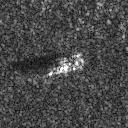

mode RGB
label 2s1


In [8]:
mstar_example = raw_dataset['train'][0]

display(mstar_example['image'])
print(f"mode {mstar_example['image'].mode}")
print(f"label {mstar_labels[mstar_example['label']]}")

### Define train, validation and test splits

The `datasets.load_dataset` function creates a `train` split by default. By applying the [`datasets.Dataset.train_test_split`](https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/main_classes#datasets.Dataset.train_test_split) method we can partition the dataset defined above into `train`, `valid` and `test` splits that are contained in a [`datasets.DatasetDict`](https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/main_classes#datasets.DatasetDict).

In [9]:
train_dataset = raw_dataset['train'].train_test_split(
    test_size=3/10,
    stratify_by_column='label'
)

test_dataset = train_dataset['test'].train_test_split(
    test_size=2/3,
    stratify_by_column='label'
)

mstar_dataset = datasets.DatasetDict(
    {
        'train': train_dataset['train'],
        'valid': test_dataset['train'],
        'test': test_dataset['test']
    }
)

mstar_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 134
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 270
    })
})

### Dataset statistics

Using the Hugging Face [`map`](https://huggingface.co/docs/datasets/v2.19.0/en/image_process#map) function that can apply a transform over an entire dataset, we can produce simple statistics that summarize the data. For example, the `count_labels` function accumulates counts per split of the number of objects of each category that are then used to create a Pandas dataframe.

In [10]:
def count_labels(ds: datasets.Dataset) -> list[int]:
    ctr = collections.Counter()
    def inc_label(l: int) -> None:
        ctr[mstar_labels[l]] += 1
    ds.map(inc_label, input_columns=['label'])
    counts = [ctr[l] for l in mstar_labels]
    return counts

df = pd.DataFrame(
    {split: count_labels(mstar_dataset[split]) for split in mstar_dataset.keys()},
    index=mstar_labels
)
df

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/270 [00:00<?, ? examples/s]

,train,valid,test
2s1,122,17,35
bmp2,75,11,21
btr70,64,9,19
m1,90,13,26
m2,90,13,25
m35,90,13,26
m548,89,13,26
m60,123,17,36
t72,76,11,21
zsu23,122,17,35


A bar chart of the category counts clearly reveals the real MSTAR data is fairly balanced.

<Axes: title={'center': 'MSTAR Class Counts'}>

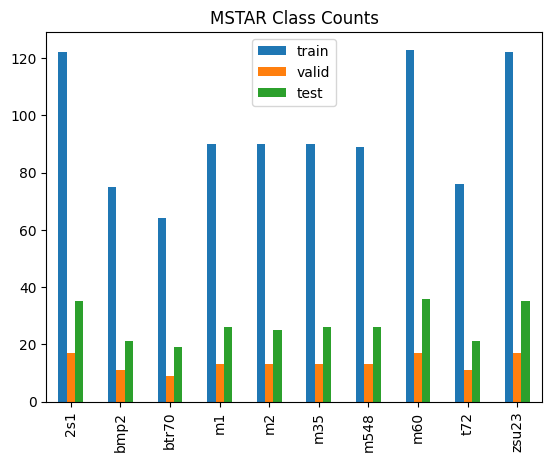

In [11]:
df.plot(kind='bar', 
        stacked=False, 
        title='MSTAR Class Counts') 

### Saving to Disk or Uploading to S3 Bucket

The new MSTAR dataset may be [saved to disk](https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/main_classes#datasets.Dataset.save_to_disk) among other options.

In [12]:
mstar_path =  Path('mstar_10.hf')    
mstar_dataset.save_to_disk(mstar_path)
    
print("Loading the dataset")
print(datasets.load_from_disk(mstar_path))

Saving the dataset (0/1 shards):   0%|          | 0/941 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/134 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/270 [00:00<?, ? examples/s]

Loading the dataset
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 134
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 270
    })
})


## Integrate into Armory

Having imported a SAMPLE subset as a Hugging Face dataset, we are ready to plug our new dataset into the Armory Library framework. This consists of creating an `armory.dataset.ObjectDetectionDataLoader` that defines the underlying [PyTorch dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). Note that the `armory.data.Scale` object defines the type and scale of the data. The Armory dataloader is then wrapped by an `armory.evaluation.Dataset`.

In [13]:
batch_size = 16
shuffle = False

unnormalized_scale = armory.data.Scale(
    dtype=armory.data.DataType.UINT8,
    max=255,
)

mstar_dataloader = armory.dataset.ImageClassificationDataLoader(
    mstar_dataset['train'],
    dim=armory.data.ImageDimensions.CHW,
    scale=unnormalized_scale,
    image_key="image",
    label_key="label",
    batch_size=batch_size,
    shuffle=shuffle,
)

armory_dataset = armory.evaluation.Dataset(
    name="MSTAR-qpm-real",
    dataloader=mstar_dataloader,
)

armory_dataset

Dataset(name='MSTAR-qpm-real', dataloader=<armory.dataset.ImageClassificationDataLoader object at 0x2ce0530d0>)

## Resources
- [SAMPLE Public Dataset](https://github.com/benjaminlewis-afrl/SAMPLE_dataset_public)

- [Lewis, B., Scarnati, T., Sudkamp, E., Nehrbass, J., Rosencrantz, S., & Zelnio, E. (2019, May). A SAR dataset for ATR development: the Synthetic and Measured Paired Labeled Experiment (SAMPLE). In Algorithms for Synthetic Aperture Radar Imagery XXVI (Vol. 10987, pp. 39-54). SPIE.](https://github.com/benjaminlewis-afrl/SAMPLE_dataset_public/blob/master/sample_public.pdf)
